## XGBoost

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import json
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Pre-processing for XGBoost

In [16]:
# read the dataset from data exploration step
df_energy_weather = pd.read_csv(
  "input data/energy_weather_table.csv",
  parse_dates=['dt_iso']
)

# parse date-time and set as index
df_energy_weather['dt_iso'] = pd.to_datetime(df_energy_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_energy_weather = df_energy_weather.set_index('dt_iso')

In [17]:
# Generate 'hour', 'weekday', 'month', and 'year' features
# this will help in the modeling later
for i in range(len(df_energy_weather)):
    position = df_energy_weather.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    year = position.year
    df_energy_weather.loc[position, 'hour'] = hour
    df_energy_weather.loc[position, 'weekday'] = weekday
    df_energy_weather.loc[position, 'month'] = month
    df_energy_weather.loc[position, 'year'] = year

In [18]:
# save dropped columns which will be returned later to the dataset
df_droppped = df_energy_weather[['forecast_solar_day_ahead','forecast_wind_onshore_day_ahead',
                                 'total_load_forecast', 'price_day_ahead',
                                 'generation_solar','generation_wind_onshore','year']]
# filter on year 2018
df_droppped = df_droppped[df_droppped.year == 2018.0]


# drop all forecast from data for for modeling later
df_energy_weather = df_energy_weather.drop(columns=['forecast_solar_day_ahead','forecast_wind_onshore_day_ahead',
                                                    'total_load_forecast', 'price_day_ahead'])

# drop generation which for wind and solar aside from totals
df_energy_weather = df_energy_weather.drop(columns=['generation_solar','generation_wind_onshore'])

In [19]:
# exclude 'object' types since the model will accept numeric values only
df_energy_weather_proc = df_energy_weather.select_dtypes(exclude=['object'])
df_energy_weather_proc.head()

,generation_fossil_brown_coal_lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_biomass,generation_other_renewable,generation_waste,...,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,hour,weekday,month,year
dt_iso,,,,,,,,,,,,,,,,,,,,,
2015-01-05 20:00:00+00:00,0.0,5329.0,2804.0,326.0,0.0,1328.0,3732.0,370.0,74.0,161.0,...,108.0,0.0,0.0,0.0,0.0,800.0,20.0,0.0,1.0,2015.0
2015-01-13 10:00:00+00:00,908.0,5992.0,6823.0,335.0,47.0,936.0,4358.0,502.0,64.0,267.0,...,238.0,0.0,0.0,0.0,0.0,800.0,10.0,1.0,1.0,2015.0
2015-01-13 17:00:00+00:00,932.0,8464.0,7068.0,359.0,0.0,1072.0,4544.0,535.0,76.0,263.0,...,295.0,0.0,0.0,0.0,0.0,800.0,17.0,1.0,1.0,2015.0
2015-01-14 12:00:00+00:00,940.0,6446.0,7568.0,359.0,1.0,1031.0,4199.0,533.0,73.0,272.0,...,253.0,0.0,0.0,0.0,0.0,800.0,12.0,2.0,1.0,2015.0
2015-01-24 15:00:00+00:00,512.0,3099.0,5622.0,288.0,646.0,1053.0,1128.0,498.0,78.0,213.0,...,241.0,0.0,0.0,0.0,0.0,800.0,15.0,5.0,1.0,2015.0


In [20]:
# save final working dataset
df_energy_weather_proc.to_csv('input data/energy_weather_table_proc.csv', index=True)

## Predicting price, load, solar and wind output

In [21]:
# main function for prediction and output model performance
# actual_column = the target column to predict
# model_name = the name of our model, it will be used to save the model performance
def predict_df(actual_column, model_name, xgb_best_params):
    X = df_energy_weather_proc.drop(columns=[actual_column])
    y = df_energy_weather_proc[actual_column]
    
    data_dmatrix = xgb.DMatrix(data=X, label=y)
    
    data_train = df_energy_weather_proc[df_energy_weather_proc.year != 2018.0]
    
    X_train = data_train.drop(columns=[actual_column])
    y_train = data_train[actual_column]
    
    data_test = df_energy_weather_proc[df_energy_weather_proc.year == 2018.0]
    
    X_test = data_test.drop(columns=[actual_column])
    y_test = data_test[actual_column]

    # xgboost hyperparameters
    xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=xgb_best_params['colsample_bytree'],
                          learning_rate=xgb_best_params['learning_rate'], max_depth=xgb_best_params['max_depth'],
                          min_child_weight=xgb_best_params['min_child_weight'], alpha=10,
                          n_estimators=xgb_best_params['n_estimators'], subsample=xgb_best_params['subsample'])

    xg_reg.fit(X_train,y_train)

    # initialite predicted values using the model and test data
    preds = xg_reg.predict(X_test)

    # cross validation
    cv_results = xgb.cv(dtrain=data_dmatrix, params=xgb_best_params, nfold=3,
                        num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

    # save model output
    cv_results.to_csv('output data/xgb/' + model_name + '.csv', index=True)

    # visualize feature importance
    xgb_model = xgb.train(params=xgb_best_params, dtrain=data_dmatrix, num_boost_round=10)

    xgb.plot_importance(xgb_model, max_num_features =20)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.title("Feature importance for " + model_name)
    plt.show()

    # save feature importance dict to json
    data = xgb_model.get_score(importance_type='weight')
    with open('output data/xgb/' + model_name + '_feature_importances.json', 'w') as fp:
        json.dump(data, fp)

    # return the output prediction, this will be appended to our test dataset for 2018
    return preds

[03:00:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

C:\Users\jeanc\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-22-f7542d3ffeb7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test['price_predicted'] = predict_df('price_actual', 'xgb_price', xgb_price_params)
<ipython-input-22-f7542d3ffeb7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test['total_load_predict

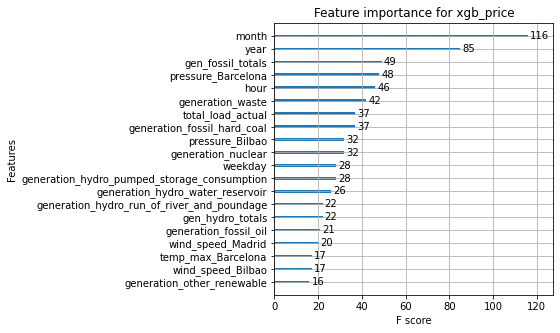

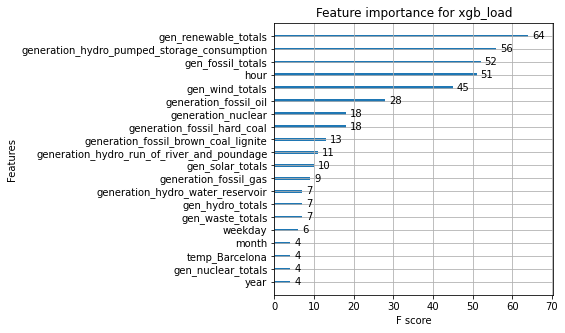

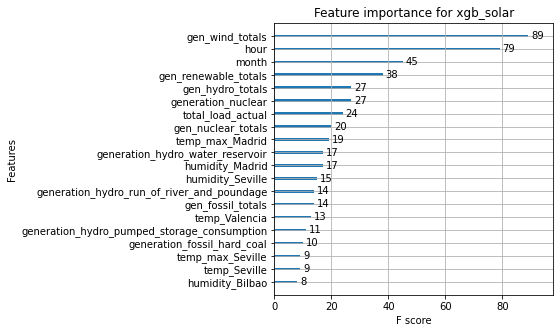

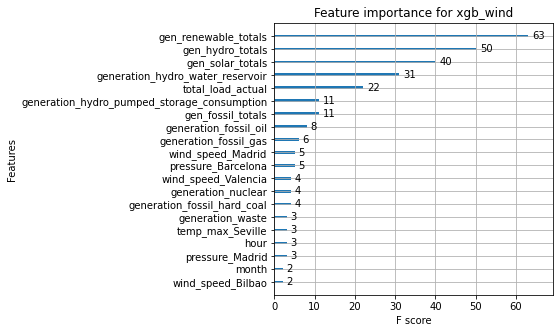

In [22]:
# use the main function to predict and save model performance
df_final_test = df_energy_weather_proc[df_energy_weather_proc.year == 2018.0]

# load best params value from grid search
xgb_price_params = {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4,
                    'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
xgb_load_params = {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4,
                   'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
xgb_solar_params = {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 4,
                    'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
xgb_wind_params = {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 4,
                   'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

# save the predicted values to the datatest
df_final_test['price_predicted'] = predict_df('price_actual', 'xgb_price', xgb_price_params)
df_final_test['total_load_predicted'] = predict_df('total_load_actual', 'xgb_load', xgb_load_params)
df_final_test['gen_solar_totals_predicted'] = predict_df('gen_solar_totals', 'xgb_solar', xgb_solar_params)
df_final_test['gen_wind_totals_predicted'] = predict_df('gen_wind_totals', 'xgb_wind', xgb_wind_params)

## Save the resulting test dataset predictions

In [24]:
# return the dropped columns
df_final_test = pd.concat([df_final_test, df_droppped], axis=1)

# save resulting test dataset as energy_weather_table_xgb_preds for the Viz
df_final_test.to_csv('output data/xgb/energy_weather_table_xgb_preds.csv', index=True)
